In [1]:
import cloudscraper
from bs4 import BeautifulSoup as soup
import pandas as pd
import numpy as np
from datetime import datetime
import time
import re
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [2]:
scraper = cloudscraper.CloudScraper()  # returns a CloudScraper instance
# Or: scraper = cloudscraper.CloudScraper()  # CloudScraper inherits from requests.Session

In [3]:
STANDARD = ['anime/','book/','cartoon/','comic/','game/','misc/','movie/','play/','tv/']
CROSSOVER = ['crossovers/' + temp for temp in STANDARD]

In [4]:
df = pd.DataFrame({'fandom':[],
                   'count':[],
                   'type':[],
                   'href':[]})
for i in range(len(STANDARD)):
    TYPE_HTML = soup(scraper.get("https://www.fanfiction.net/"+STANDARD[i]).text)
    typetext = STANDARD[i][:-1]
    #print(typetext)
    
    x = TYPE_HTML.find("div", {"id":"list_output"})
    FANDOM = [h.get('title') for h in x.find_all('a')]
    NUM = [h.text[1:-1] for h in x.find_all('span')
           if bool(re.match('[0-9]+K?',h.text[1:-1]))]
    HREF = [h.get('href') for h in x.find_all('a')]
    
    #print(FANDOM[0],NUM[0],HREF[0])
    
    dfi = pd.DataFrame({'fandom':FANDOM,
                   'count':NUM,
                   'type':[typetext for x in range(len(FANDOM))],
                   'href':HREF})
    
    df = df.append(dfi)
    
    time.sleep(1.5)

In [5]:
df["count"] = df["count"].replace({"K":"*1e3", "M":"*1e6"}, regex=True).map(pd.eval).astype(int)
df = df[df['count']>=30].sort_values('count',ascending=False).reset_index(drop=True)

In [6]:
df.head(25)

,fandom,count,type,href
0,Harry Potter,836000,book,/book/Harry-Potter/
1,Naruto,436000,anime,/anime/Naruto/
2,Twilight,221000,book,/book/Twilight/
3,Supernatural,126000,tv,/tv/Supernatural/
4,Inuyasha,121000,anime,/anime/Inuyasha/
5,Hetalia - Axis Powers,119000,anime,/anime/Hetalia-Axis-Powers/
6,Glee,108000,tv,/tv/Glee/
7,Pokémon,101000,game,/game/Pok%C3%A9mon/
8,Bleach,85300,anime,/anime/Bleach/
9,Percy Jackson and the Olympians,79200,book,/book/Percy-Jackson-and-the-Olympians/


<AxesSubplot:ylabel='fandom'>

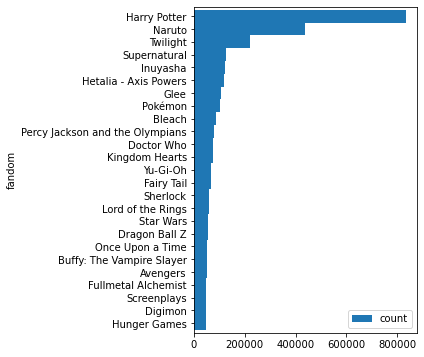

In [7]:
df.head(25).sort_values('count',ascending=True).plot.barh(x='fandom',y='count',figsize=(4,6),width=1)

In [8]:
fandomL = []
titleL = []
hrefL = []
completeL = []
reviewL = []
summaryL = []
ratingL = []
languageL = []
genreAL = []
genreBL = []
chaptersL = []
wordCountL = []
reviewCountL = []
favoriteCountL = []
followCountL = []
updateDateL = []
publishDateL = []
characterListL = []

reviewSort = "?&srt=3&r=10"
favoriteSort = "?&srt=4&r=10"
followSort = "?&srt=5&r=10"
page = ["&p=1","&p=2","&p=3","&p=4","&p=5","&p=6","&p=7","&p=8","&p=9","&p=10"]

for i in range(25):
    print(df.loc[i]['fandom'],"\n")
    URLlist = []
    FANDOM_URL= "https://www.fanfiction.net" + df.loc[i]['href']
    fandomURLsorts = [FANDOM_URL + s for s in [reviewSort, favoriteSort, followSort]]
    for s in fandomURLsorts:
        for p in page:
            URLlist += [s+p]
    for URL in URLlist:
        p = soup(scraper.get(URL).text)
        for q in p.find_all("div", {"class":"z-list zhover zpointer"}):
            fandomL += [df.loc[i]['fandom']]
            titleL += [q.a.text]
            print(q.a.text)
            hrefL += [q.a.get("href")]
            reviewL += [q.find("a",{"class":"reviews"}).get("href")]
            summaryL += [re.sub("Rated: (?:K|K\+|T|M|MA).+","",q.div.text)]
            stats = re.findall("Rated: (?:K|K\+|T|M|MA).+",q.div.text)[0]
            attrs = stats.split(" - ")
            ratingL += [attrs[0].split(" ")[-1]]
            languageL += [attrs[1]]
            
            if "Chapters:" in attrs[2]:
                genreAL += [""]
                genreBL += [""]
            else:
                genre = attrs[2]
                if "Hurt/Comfort" in genre:
                    genre = re.sub("Hurt/Comfort","Hurt-Comfort", genre)
                genre = attrs[2].split("/")
                genreAL += [genre[0]]
                if len(genre) == 2:
                    genreBL += [genre[1]]
                else:
                    genreBL += [""]
            
            chaptersL += [int(re.findall("Chapters: ([0-9,]+)",stats)[0].replace(",",""))]
            wordCountL += [int(re.findall("Words: ([0-9,]+)",stats)[0].replace(",",""))]
                
            if re.findall("Reviews: ([0-9,]+)",stats) == []:
                reviewCountL += [0]
            else:
                reviewCountL += [int(re.findall("Reviews: ([0-9,]+)",stats)[0].replace(",",""))]
            
            if re.findall("Favs: ([0-9,]+)",stats) == []:
                favoriteCountL += [0]
            else:
                favoriteCountL += [int(re.findall("Favs: ([0-9,]+)",stats)[0].replace(",",""))]
            if re.findall("Follows: ([0-9,]+)",stats) == []:
                followCountL += [0]
            else:
                followCountL += [int(re.findall("Follows: ([0-9,]+)",stats)[0].replace(",",""))]
                    
            dates = [int(d.get("data-xutime")) for d in 
                     q.find("div", {"class":"z-indent z-padtop"}).find_all("span")]
            updateDateL += [datetime.fromtimestamp(dates[0])]
            if len(dates) == 1:
                publishDateL += [datetime.fromtimestamp(dates[0])]
            else:
                publishDateL += [datetime.fromtimestamp(dates[1])]
            if 'Complete' in attrs[-1]:
                completeL += [1]
                if 'Published' not in attrs[-2]:
                    characterListL += [attrs[-2].split(", ")] #needs modification for shipping
                else:
                    characterListL += [""]
            else:
                completeL += [0]
                if 'Published' not in attrs[-1]:
                    characterListL += [attrs[-1].split(", ")] #needs modification for shipping
                else:
                    characterListL += [""]
    print("\n")

Harry Potter 

Rebuilding
Harry Potter and the Methods of Rationality
New Blood
Harry Crow
Isolation
Harry Potter and the Prince of Slytherin
Partially Kissed Hero
The Marriage Stone
An Aunt's Love
Oh God Not Again!
The Rise of the Drackens
Hogwarts School of Prayer and Miracles )
Short Story Drabbles
The Debt of Time
Pet Project
Odd Ideas
The Contract
Like Brothers
The Wrong Strain
Tip of My Tongue
Harry's New Home
A Cadmean Victory
The Life and Times
A Marauder's Plan
Make A Wish
Invisible
Prince of the Dark Kingdom
Harry Potter and the Daft Morons
A Second Chance
Last Year
To Shape and Change
Poison Pen
Casting Moonshadows
Realizations
Dodging Prison and Stealing Witches - Revenge is Best Served Raw
Not Your Usual Veela Mate
Chasing The Sun
Harry Potter: Junior Inquisitor
The Reclamation of Black Magic
Death of Today
Family Bonds
Better Be Slytherin!
Harry Potter and Future's Past
Willing
Lily Potter and the Witches of Salem
Turncoat
Bound to Him
Delenda Est
To Be a Slytherin
When A

What We're Fighting For
Betrayed
His Angel
In the Mind of a Scientist
Harry Potter and the Quantum Leap
Redemption
Letters
Altered Destinies
Passageways
The Lip-Lock Jinx
Full Circle
The Muddy Princess
The Vanishing Cabinet Of Time
Banking on Her
Moratorium
Cold blood
To Call A Place Home
Cauterize
It's My Life
Harry Potter and the Marriage Contracts
Adventures in Magick
The Grass Is Always Greener
Café
Of Lies and Deceit and Hidden Personas
Prince of the Dark Kingdom
The Accidental Bond
Back Again, Harry?
Whispers in the Night
Harry Potter and the Betrothal Contract
Forging Destiny
Lily Potter and the Worst Holiday
Storm of Yesterday
What the Room Requires
Novocaine
No Thanks
Not Your Usual Veela Mate
Rebirth
Taking Control
Escapologist Harry
Rebuilding
Embracing His True Self
Double Back
Silver Tongue
The Paths Diverge
World Enough and Time
Harry Potter and the Connection Reversed
The Art of Hidden Personas
Triwizard Tales
Harry Potter and the Rejected Path
The Perils of Innocence
Ap

Son of the Sannin
Life in Konoha's ANBU
Sakura's Rinnegan
Chronicles of My Shinobi's Way
The Melt
Naruto: Myoushuu no Fuuin
All Started With A Smell
MAKE DESTINY PART II : Rise of Darkness
The Girl From Whirlpool
House of Crows
New Savior (Volume II) : Hell Boy
Sealed Legacy
Black Flames Dance In The Wind: Rise of Naruto
Ripples
Students of the Snake
Take Two Round Two
An Uzumaki Amongst the Dunes
Naruto One Man Team
Phoenix Rising
This Time Around
Naruto: The Game of Life
I Am NOT Going Through Puberty Again!
Seals are Easy, People are Hard
Konoha: Naruto's Playground
The Melody of the Fox
The Way of the Wind
Chance for a Prophecy
The Last Prayer
Masters of Genjutsu
The Sharingan Devil
Door Number Two
The Lives Worth Saving
Legacy of the Rasengan I: Naruto
Just Like Heroin
A Twist in Time
Sakura
The Golden Fox
Golden Cage
Shy Blossom
Chipped Mask
Duty Before Honor
Sanitize
Dark Uzumaki Naruto
Kage no Naruto
Lawless
Desert Flower
Clearing Mist
Little Piece of Heaven
The Ultimate Uke Sy

ANBU BRAT
The life and times of Hatake Kakashi, nukenin
A Testament of Things that Never Will
God of Illusion, Host of the Devil's Arm
Guardian Angel of Trouble Twins
Walking Backwards on a Tightrope
Naruto of Chaos
A Foxes Tale
Vespertine
The Demilitarized Zone
Way of the Rattlesnake
Stripped Bare
How Naruto Screwed With History and Changed A Lot of Things
Uzumaki Chronicles: The Swirling Tides
Reload
A Family of Foxes & Snakes: Rewind!
Loophole
Naruto : Advent of the Flash
Lone Wolf
Sit Upon the Frozen Heavens
Accidental Companions
Blonding
Spider Thread
A Snake's Obsession
Naruto: Rise of the Lord of Foxes
Team 8
Dreaming of Sunshine
A Drop of Poison
Naruto: Myoushuu no Fuuin
Naruto: The Game of Life
Seals are Easy, People are Hard
Better Left Unsaid
The Prodigy Namikaze
The Lives Worth Saving
Uzumaki Naruto: Dawn of the Gamer Remastered
Sanitize
Naruto: The Gamer Files
Common Sense
Dark Phoenix of Konoha
Outfoxed
The Sealed Kunai
Chiaroscuro
True Potential
Tale of the Setting Sun
N

After Jane Died
The Best I Ever Had
The Slowest Burn
Objects In Mirror Are Closer Than They Appear
Tip of the Spear
The Breakers
A Thousand Leaves
Indecent Proposal
Barely Breathing
Badlands
The Heir and the Spare
The Art Teacher
La canzone della Bella Cigna
Dodge and Burn
Begin Again
Guardian
Breaking News
Eye Candy
No Place Like Home
Pinky Swear
El corazon de Edward Cullen
If You Could Read My Mind
Coloring Outside the Lines
Indelible
La tienda de disfraces
Scarlet
A Servant Wife
The Boy At Table Seven
Age of Consent
The Tutor
All the Wild Horses
Rabbit Heart
Over The Top
The Fallout
The American President
Letters to Corporal Masen
The Agreement
Breaking Trinity
Work in Progress
Life's Little Choices
La chica del rincón
A Betting Man
Altered Measure
This Is Who I Am
Readjusted
Shadowboxer
Training the Swan
The Single Game
Going Under
What Happens in Vegas
Changing My Course
Our Lives Unbound
Come Back Tomorrow
That s What Little Girls Are Made Of
My Biggest Mistake, My Greatest Salva

The Plan - OUTTAKES
The Agreement
Dusty
Pinky Swear
Shadowboxer
Written in the Stars
Breaking News
The American President
Persisting Occurrences
Accidentally in Love
Insatiable Desires
Love in My Box
No Holds Barred
The Boy At Table Seven
High Heels and Runaway Frisbees
We Come to Life Beneath the Stars
The Wedding Party
Sexy Silk
Just One of the Guys
Fall to Ruin One Day
Training the Swan
Bella Swan: Kidnapper
You Came Too Early
La canzone della Bella Cigna
Paper CutOuts
Bare
Sleep On The Floor
Nobody's Little Girl
The Devil You Know
High Fidelity
Holding Out For You
Starry Eyed Inside
Silver Strand Nights
My Biggest Mistake, My Greatest Salvation
Evading Edward
Work in Progress
Little Green and Easybella
Breaking Bella
Secret Sex
Because of a Scar
For the love of a King
Twilight'd
Animate Me
The Screamers
Code Name: Nanny
The Hard Way To Learn A Lesson
No Choice
Reign
Words with Strangers
Faking It
Facebook Friends
The Ex Factor : Edward & Bella
Coming Home
A Woman Scorned
Caught Loo

Second Childhood
Cas' Milkshake
Leap That Makes the Fall
Saving Grace
Coming Down on a Sunny Day
Strangers and Angels
The Reluctant Contestant
Us Against the World
A Hand
The Holiday
Crash
Black As Night
Not Usually a Good Thing
txt msg
That's My Story
Little Child
Soldier Boy
Sure Got a Dirty Mouth
The Obeisance of Memory
Along Came Sophie
And I Shall See His Glory
A Series of Unfortunate Texts
Living Expenses
In Shadow
Rest Your Weary Head
It's The Great Destiel Shipper, Sam Winchester
Castiel and Slash Fiction
Fellowship of the Nine
Not All That
He Ain't Heavy, He's My Brother
One Saved Message
The Promise
Supernatural Drabbles
Print
The Piano
Bonded
Four Things That Remind Me of Love
Whiskey
Bring It On Home
Goodnight, Moon
A Brief Glimpse
Entertaining Angels
When Angels Fall
Supernatural: Today Your Barista Is
To End Your Suffering
For Love is Strong as Death
Apples
Raising Angels 101
Destiel, Actually
Lost Brother Found
The Road So Far (this Time Around)
Unlikely Places
Hold Me C

Too Close to the Ground
Best Laid Schemes
Weird Dean
Stepping In
Whiskey
Genius
Spin Cycle
More Than Enough
Bring It On Home
The Broken Road That Led Me Straight To You
See No Evil
Family is Everything
Crossing Over
Becoming a Winchester
I'll Have The Usual
All The King's Men
Growing pains
The Youngest Winchester
Grand Theft Vessel
Birdcage Fires
Master of My Domain
Escalation
A Friend For The End
Bunker Rules
The Mirror


Inuyasha 

Lord Charming
Unspoiled
Dead Famous
The Once and Future Taiyoukai
I Dare You
Tales From the House of the Moon
A Tale of Ever After
Second Chance
Taste of Love
Clutter
Zero G
Imperceptible
Bottled Genius
Through the Looking Glass
Twisted Hearts
Behind the Masquerade
Winter Wonderland
Unexpected
Impeccable
Possession
From Hatred To Love
To Summon a Mate
The King's Mistress
Turnabout is Fair Play
Kindergarten Flirting
The Accession
Time for a change
Shikuro: A Caribbean Fairy Tale
Beside You in Time
The Syndrome
Being Backstage
Enchanted Orbs
The Babysitter
E

Bitten
Transcending Time
The Pain
Misery loves company
Vacation with the Boss
Pose
Pure Heart
Onyx Eyes
A Miko's Love
His Past, Her Present, Their Future
My Mate
Pages of the Heart
God in Sunlight
From Friendship to Love
Shattered
Hello Daddy!
Perfectly Flawed
Perfection
Mate
My Experiment
Everyday Love
History Lessons
Letters
Could Be Raining
Prisoner, My Prisoner
A Cross of Blades
Enter the Wolf's Den
Alter Ego
Black Blood
The Cursed Monk
Different, Yet so Alike
The Price
Embracing Ice
All It Took Was A Simple Mistake
In Heat
The Accession
Trapped Together
Bodyguards
Ice and Snow, Mind and Heart
Like Father, Like son
Eyes Wide Open
Utter Doom
Providence, perhaps?
A Mere Digression
As You Wish
A Second Chance At Love
Fan Mail
The Silver Dove and The Raven
Desire
Kagome's trust
Unspoiled
Lord Charming
Pack
Blast from the Past
Beside You in Time
The Once and Future Taiyoukai
To Protect the Alpha Female
A Demon Lord's Cry
Imperceptible
Till The World Stops Turning
Remembering
Heat of Rea

Run Fast, Turn Left
The Confidants' Club
What a Brother! What a Bother!
A Matter of Course
Barbarians Healer
In the Shadow of Wonderland
Critical Hit
The Pirate's Treasure
Ebene
Proof of Existence
The Other Side Of The Mirror
The Cafe Of Double Lives
Short Stories With Happy Endings
Memories of Old
Ciao…Guess I'll write these damn letters now
Why Her?
And All That Jazz
Anything and Everything Awesome
Beautiful Nightmare
Hetalia X Reader: Romantic meetings
From Child to Hero
Psycho
Through the Silence
Ask Me Anything
Truth or Dare?
Vee I get to write letters too?
Between Angels and Demons
Just What You're Looking For
Brother Complex
Ice Revolution
Hello Hurricane
Bandeja de plata
The Tell Tale Heart's
Oh God, Get Me Out!
Why Me?
Letters, Fresh From The Pan!
Postals to Panama!
Sophomore Slump or Comeback of the Year
A tres pasos de ahorcarte
Our Lives as the Republic of the Philippines!
Become One With Mail
Why Did it Have to be You?
Ya Puede Besar al Novio
Where Did The Moon Go?
America

Presidential Initiation
American Wife
Secrets From America
HetaOni
Not just a fling
Let Me In
When You Recover
National Security
Hell to Pay
Become One With Canada
Clinging
Shades of Innocence
Jones Paranormal Investigation Agency
The Great Curl Debacle
Barbarians Healer
Never Your Hero
The Danish Slaughterhouse
If I Die Young
Before They Learn To Swim
Into the Herd
Hunger
Strange Things Happen At Night
Vigilant
Transparency
Child Services
And Three Makes Five
Under Men's Clothing
Choose Me Or Your Pyre
Breathe Me
No Such Thing As Coincidence
In Want of a Wife
The Cafe Of Double Lives
The Companion
Welcome To My Life
Unexpected
Numbered Lithograph
Memories of Old
Labyrinth
CAN you see US?
The Queens of the Suits
A New Life
Discovered
Confessions of a Cat Owner
It's just going to be you and me
Soul Mate
What it means to be a big brother
The Taboo
Outcast
Don't You Know Which Clothes Even Fit Me?
Secret Memories
Vampires and Werewolves
Aeternus Amor Meus
Finding Freedom
I'm Starting To T

Dalton
Go Your Own Way
I'll Be
Should Have Asked for Directions
The Sidhe
2859
Roses in December
Just off the Key of Reason
Beautiful When You Don't Try
I'll Teach You to Dance
Influence
This Kiss
Kissing Quinn Fabray
Clockwork
If Only You Could See What I See
What Doors May Open
Color
Room 47
Taking The Long Way
Music Box
Rough Beginnings
Past Mistakes
Kiss
Simple Parts
It's Not Like I Wanted This to Happen
Crazy on You
Sideways
I Need a Medic
Serendipity
7 Minutes
The Silence of Silence
I've Been Looking for You Forever
Mischances, Stances and Stolen Glances
The Kitten and Coyote
The Girl Next Door
Threads of Maybes and Might Have Beens
Outsiders
Of Bear Cubs, Meerkats, and Hobbits
(I've Never Reached An Answer) I'm Only Given Clues
Dance On Our Graves
We'll All Float On
Set the World on Fire
Coffee Breaks
A Million Miles Of Fun
Syrup and Honey
Ride
Blue Creek Lodge
You Hit Like a Girl
Daddies
Hate That I Love You
As If We Never Said Goodbye
Still off the Key of Reason
Leave Me Alone

First Bite
Letterman jacket
Help
Just Doing Her Job
The South Side of Anywhere
Get That Chance
Worthless Priceless
Ordinary Girl
Bully and Benefits
Dance On Our Graves
Little Duckling
Secret Sky
We're Just Getting Started
The Quest for Rachel Berry's Heart
Burn The Whore House (To The Ground)
At the End of the Day
A little love along the way
An Unholy Alliance
Somewhere in Between
Echo
Never Let On
Only You Can Save Me
I Will Be Your Comfort
Broken Bird Sing
Convince Me
Triquetra
A Change of Plans
The Power of DVD
Our Little Arrangement
Syrup and Honey
The Secrets: Hidden behind the Mask
Tainted Star
A Morning Dedication
Fabray's Way
So Falls the World
Pour Some Slushy On Me
Drawing The Line
Baby Bottle Brews
Story teller
Love me That's All I Ask of You
How To Save A Life
I love you, nerd
Worlds Apart
Never Let Me Go
Wherever the Dandelion Falls
Haven't Forgotten My Way Home
Marking A Mate
Reasons that I Laugh and Breathe
Heartwood
Sirens
Shattered
Nothing Is Right When You're Pretendi

Eden
Ascension
Aura Heart Journey
From One Side to Another
Play it again, Ash
On Brave Mountains We Conquer
Ashlyn Ketchum: Pokemon Champion
Aura Master: Kanto and Orange Islands
Uprising
Pokemon - I can level up too!
Road to a Master
A True Champion
Pokémon Platinum: The Rise of a Master
Champion's Revived Glory
Fighting Alone
A New World
Pokémon Mystery Dungeon: Silver Resistance
Journey of a Master
When One Ends
The Trainer From A Far Away Land
A Child of Two Worlds
Dragonfall
When One Door Closes, Two More Open
Another Road
A Surprising Journey: Kanto Arc
Spot Inspection
Unexpected Twist
Champion of Champions
The Wanderer
Alola to our Saviour
Pokémon: The great adventure
Another Journey
Loyal to the Game
A walk alone
Ash's Master Quest
World Class Skill!
Secrets
Slow Down A New Beginning
Kanto's Champion
The Life of PokeSexuals
A courageous heart
Rise of a Legend
Ash, an Inspiration
Speak Up
A New Journey
The Rogue
Neverending Pokemon Romances
The Very Best
Alola, Galar!
Journey To

Lost Friendships
Like a Boss
Start of a Legend
A moment of clarity
Rogue 2: The Redeemed
The Crimson Guardian
Ashes In The Sky
The Return of the Betrayed Guardian
Pok'emon: Ashs Adventure
Gardevoir
The Final Battle
GKEA: Sinnoh Saga
Ultimate Frontier Brain
Ash 'Red' Ketchum
The Road to be a Pokemon Master: Hoenn Arc
The Bonds We Share
AAML: Diamond and Pearl version
Kanto's Guardian
Proven
Romances of the Pokemon World
The Master Path
A Different Path
Titans
The Road to Champion
Boundless Love: The Tale Of Athena
Without Any Meaning
Monster Under The Mountain
Master Quest!
Pokémon: Legends of Johto
Misfits
Tales of Ash: Kanto Chronicles
To Repair With Gold
The Road Ahead
Master of the Legendaries
The Child of Mew: The Great War
Pokegirl Origin
Blessed By Victory
Genius Reborn
Revival at the Champions League
The Champion's Protégé
Ash Ketchum: Being More
Saga of a Rising Legend
A Pink Surprise
A Path Stained Red
The World's in Your Hands
Path of the Master
The One
Feel Invincible
The Tr

Quincy Craft
Bleach - Ichigo, The First Gamer
Best I Am
The Next Generation
The Brightest Shinigami
Ichigo's New Job V2
A Second Chance
Vow of the King
Change of Fate
Run Ichigo Run
Stranded
Reforging the Blade
Between Me and Thee
Sin
F U R A R E T Axx
Here Kitty Kitty
Morning hazards
Kingdom Come
Don't Judge A Fanfiction By Its Summary
Three Powers
Operation: Big Brother
What Binds Us Together
You, Me, and Baby
I'm Psycho, Baby
Bands & Berries
When Bad Days Turn Good
Tell Me Tomorrow
CANDY
Lovedotcom
Parent Teacher Conference
The Creation Sin and Destruction Monk
Indefinitely
Murder My Heart
To Overcome the Love of Many Women
Things Shinigami are not allowed to do
Hollow, Misunderstood
Force of Souls
Congratulations! It's a Ichigo?
Death and the Strawberry
Heavenly Light
Substitute School, First Semester
Tear It Up
Gaining Respect
My Inspiration
Bakudo X: Life is a Game
A Hollow Queen's Dark Knight
The Forgotten Secrets of Soul Bonds
Unexpected Kingdom
Sword Magnet
The Opposite Of Rea

Cinderella
Life of Percy Jackson (Pertemis)
Zayden Blaze
Frozen Body, Broken Heart
Of Corporate Scandals
The Life and Times of Percy & Annabeth
Concrete Angel
Dreams
Chasing Fireflies
Perseus and the Monster Force
Confused By Time
Hidden in the Shadows
Shattered
Son of the Moon
Princess of the Sea
25 Ways to Prank Octavian
Lost and Found
The Life-Guard and The Supermodel
The Plea of Apollo (& many Solangelo one-shots)
Love the Babysitter
Brotherband Chronicles
The Son of Vesta
Climbing Mount Everest
Exiled
Eternal Destinies
Fate Fell Short
STRUCK
Daddy Hades
Lord Perseus Child of Rome
The Stranger Within
Boy?
Meet Percabeth
Summer Love
The Son of Neptune
Broken
Percy Jackson and the Powers of Chaos
Just Another Day: PJO and HoO
Purgatory
Arcane Chaos
The Past and the Present
Demigods go to Highschool
Homecoming
Love The Goddesses
PERCABETH LOVE STORY
King of the Gods
Illogical and Stupid
At the Bar
TRUTH OR DARE
WTF
Ocean's Wings
Year of Nightmares
Moon Daughter
Blackened Dawn
All is F

Son of Hera
The Sea's Recovery
Artificial Engagement
Faded Past, Renewed Future
Love?
A Dying Romance
ATLOP: Trial By Fire
Percy Jackson and the Primordials
Half-Blood High
Struck By Lightning
pertemis love
Welcome to Olympus High
Silver Screen
The Roman Avenger
The Three Lives of Luke Castellan
Athena's New Love
The Alphas of Percy Jackson
Percy Jackson and the God of War
Immortality Suits You
Son of Lupa
Love the Babysitter
Mortality The Immortal Watcher
To Sir, With Love
He's Your Boyfriend?
A Man Without a Hearth
Uphill and Against the Wind
Flipping the Hourglass
Reading the Lightning Thief with a Twist
From Amidst The Darkness
The Betrayed One
The Wild Hunter
The Golden-Eyed Swordsman
Perseus Son of Vesta: Reborn From Ashes
Champion of the Sun: The Spartan Demigod
A Year In A Day
Midnight Doesn't Last Forever
Death's Dare
Forgotten in Marriage
In Shadowed Eyes
The Eternal Consort
The Exiles'
Brotherband Chronicles
King of the Gods
Go with the Flow
Subject 0
The Stranger Within
The

I'd Come For You
Child of Earth
Always Bad Wolf
Return to The Valiant
Doctor Who with Rose Tyler
Duplicity
In My Life
Defender of the Earth
Until The End
Just a Bit Unlikely
100 Worded Stories
Charlene, Charlene Who?
Don't touch that
Desperado
Raising Amelia
The Choice
Confessions of a Blue Box
TARDIS Drabbles Of Randomness
Once Upon Another Time: Book 1 (Archived)
Life With The Family
The Time Traveler's Life
The Most Important Thing in the Universe
Out of the Ashes
Something Old, Something New
And All the Little Deaths Before
All The Stories We Never Told
Not Quite Right
The Wedding of Rose Marion Tyler
The Other Has My Heart
Footsteps
Time Child: Metamorphosis
The Oddity Tales
Life as a Circular Paradox
It starts with Barcelona
Complicated
How to Fall in Love with a Time Traveller
New New Life
Time Child: Undone
The Time That We Love Best
A Split Second
Strange Magicks
The Long Meaningful Ramble 3: Child of the Vortex
The Long Meaningful Ramble 1: Origins
Give Her Back To Me
Games o

Taking Turns
Saving Keith: Traveling with Death
Gallifrey Stands
Time, Peace, and Serenity
Time Child: Metamorphosis
Next Stop, Everywhere
The Wolf at the Door
Distance
Paper Machine
Of Loneliness and Second Chances
Child of Earth
Never Ever
Little Star
I Am Not Like You
Someone New
Never Be The Same
What has Happened Since
Look After You
Reproduction
The Traveling Wonder
Wait
Deafening Silence
In the Sea of Memory
Female of the Species
Revelations
Through the Stars
Jumping Through Time
Don't Blink
Reality
Just a Bit Unlikely
The Dread of Tomorrow and Yesterday
Alexander-The Seer and Changer of Time
With Starlight in Their Wake
The Long and Winding Road
The Invisible Rose
Always Bad Wolf
Don't Cage the Wolf
Blooming Again
3 Doctors, 9 Companions, What Could Possibly Go Wrong?
Written In The Stars
Howling with the Storm
And All the Little Deaths Before
The Time Experiment
Crossing Timestreams
A Split Second
A Golden Rose
The Oddity Tales
Through Trials and Tribulations
For the Sake of a

99 Bottles of Beer on the Wall
Love Like Winter, Set Aflame
Beautiful Dawn
The Old Life, Alive Again
Define Sin
I Saw it on Your Forehead
A New Path, A New Wanderer
From the Inside
Multiple's of 'I Love You's
What Comes After
Kingdom Hearts Meets House of Mouse
The Seventh Apprentice
Kiss and I Will Surrender
Respect Me Not
Rules Of Cosplay
A Careful Remedy
Taming Fire
Letters to Riku
Songs and Dreams
Aquatic Angel
My Best Friend’s Girl
I Heart You: III
Reverse
Jealousy
Intertwined Destinies
Tainted But Beautiful
The Pack
sweet talk 101
Dig
Heartbreakers
Oathkeeper's Dawn
He's Going To Be Mine
Reverse Side of Darkness
Skywalkers
Oathkeeper's Awakening
Reckoning
I Heart You
Broken Hallelujah
Your Daily Caffeine Fix
Warrior, I am
It's Kai, Not Kairi
Kingdom Hearts Bonded Souls
Kingdom Hearts III: The Keyblade War
Kingdom Hearts III: Dawning War
Killing Time
Perhaps I'm Not Who I Thought I Was
ColorCoded
Half Alive
Axel's Fables
Cinderfella
Twilight Blaze
Whispered Melody
Sugar And Spice


Reconnected
99 Bottles of Beer on the Wall
Accidental Infatuation
Salacity
Eclipse of the Heart: New Moon
Boring System
Ever After
Tantalize
Neap Tides
Resident Emo
Child's Play
Life on the Blitz
The Annals of Darkness: The Beginning
Kingdom High Boarding School
The mating game
Duality
二人の約束:The Promise Between the Two of Us
Voices whisper in my Ear
Keys to the Kingdom
Finding Lost Dreams
Falling For The First Time
Vagabonds
The Roads that Bind
Those Without Hearts
Gunmetal
Living Proof
Mission Impossible
That Dream that you Chased
By Chance
Treasure
When the Circus Came to Town
Fire
Ocean Eyes
Kingdom Hearts Two re-write
The Annals of Darkness: Light's Growth
Multiple's of 'I Love You's
Serendipity
17 DAYS OF HELL
Guilty Conscience
Echo
Kingdom Hearts: Our Fated Steps
Do You Remember
Princely Garbs
Kingdom Hearts III- Reconnect The Blank Points
Crowded Elevator
Broken Rituals
Romeo and Juliette Syndrome
The Catholic and The Rebel
Mermaid's Tear
Terraforming
Sinfully Pure
Who Needs Lov

Dark Desire
What Would Yugi Do!
Something Special
Foreign xChange
The Drabbles Collection
Duel Idol!
Darkness' Addiction to Light
Love Transcending TIME
Virtually Yours
Alias of Chaos
Smirks
Truth or Dare?
Legally Insane
Old Love
Finding You
For You I'd Do Anything
Untouched
The Summer of Seduction
A Pharaoh's Visit
Haven't met you yet
Sweet Torture
Why did it come to this?
Nomead Prison
Retrieving Destiny
His Touch
Restaurant Love
New Powers From The Old Days
Lion Heart
One Door Closes, Another Door Opens
Ennead: Season Zero
The Obsession
Ruffles and Lace
Cast Away with Seto Kaiba
Return of The King
I Love The Pharaoh
The Mythology Set
The Void
Hentai Ryou
Secret Past
Behind Blue Eyes
The Dragon's Rose
Starting Over
Arranged Marriage
Ancient Egyptians watch Yu-Gi-Oh!
Dark Desires
Unsweet Silence
One Ending is the Start of a New Beginning
Save Me
Dripping Wings
You Don't Understand!
Let the beat drop
Family of Dragons
My Mates, My Life
Texts From A Stranger
A way to get lost in you
Mid

Tales of Fairies
Between the Lines
2nd Generation
Berserk
The Keys of Fire
Fairy Tail GO!
Capturing Her Damaged Heart
Child of Heaven
Parallels
Ripples
Living With Him
Of Dust and Shadows
Golem
1095 Days of NaLu
Of Myths and Monsters
Adherence
Fight Me, Bite Me
The Chase
Cute As Fuck
Replaced
More Than a Princess
Gods, Dragons, and Stars
Secret Lovers
That Unrequited Childhood Love
Her Scream
Passive Aggressive Post-Its
The Peacekeeper
Eye of the Black Dragon
Possession
Controlled Chaos
Accidentally in love
Finding Nakama
Fairy Tail
Tempest
Ignite
Bet You Didn't Know
Sunny With a Chance of Laxus
The Misfit
Fairy drabbles
Natsu Dragneel the Dual Dragon Slayer
A Fairy Tail Ending
Acnologia, My Childhood Friend
Issues
The Princess and the Pirate
Beastly Possession
Love At First Site
Master Dragneel
Calming the Chaos
The Raven
Dragon's Guide To Claim Your Mate
A Moment With You
Into The Ring
The Act Of Hatred
I never should have joined!
A Tale Or Two
Wild Aces
Mythical Creatures
Soft Storm

A Collection of Smexy NaLu Drabbles
The S-Class Mage
The Girl with the Celestial Tattoos
Parental Concern
That Unrequited Childhood Love
7 Pieces
Celestial Lightning
Dragon Senses
The Misfit
Unguarded
Rub a Dub Dub
Natsu's Growing Up
Dragon King of Fairy Tail
A Tale Or Two
Camp Dragneel
Writer's Block
Natsuki Dragneel
Burnt Cookies
The Cursed Gift
Little Lucy of Thunder
A Diary's Secret
Trading DragonSlayers
Maybe More
White Dragon Slayer's Mark
Backlash
During Those 7 Years
Sunny With a Chance of Laxus
Melee: Punch Your Way to Love
The Game
The Beginning of the END
The Meaning of Family
Soon to Come
The Ruthless Seven
Taking Care Of You
Swimming With Mermaids
I Leave You, My Pride
Reflections of the Soul
One of the Girls
Sailing with Fire
A Bond of Fire and Iron
The Next Morning
Year of the Sun
Heartstrung
Seven-Years with a Pink-Haired Kid
Strength of Spirit
Vengeance
Strongest of Them All
The Dragon and the Princess
Understanding My Heart
On the Path to Forgiveness
Unleashing The Re

A Small Miscalculation
I Am What I Am
Sherlock & John Rebellion of Angels: Acclamations
Si Brave et Si Tranquille
Un certain nombre de mots
Sui Generis
The Irregulars
Cops and Robbers
Stayin' Alive (For Two Years Per Season)
The Progression of Feelings
Crabe
Neither A Soldier Nor A Gentleman
Saving Sherlock Holmes - fr
Say Your Right Words drabble collection
We Love Sherlock
The Taming of John Watson
The Ballerina and the Consulting Detective
Worthless
The Ghost and Molly Hooper
The Science of Friendship
Sherlock: This Is War
The Laws of Family
Misdialed
Matchmaker, Matchmaker
Junkie
Possession
Making the Connection
We Keep Falling
Of Small Boys and Sandwiches
Between a Rock and a Hard Place
Through Thick and Thin
Love Ballads For the Nonbelievers
Common Grounds
The Bone Interpreter (rewritten and revamped)
Better Than None
Come Forth, Lazarus
The Laws of Familiarity
Baker Street Irregulars
Trial and Error Part One: Hamish
The Wee Doctor
Never To See The Stars Again
Ashes
The Mouse and

Because I Care
To Resist Temptation
Find Me
The Long Ride Home
A Lost Heart - An Empty Home
This Is What He Does For Fun
The Science of Deduction
A Small Miscalculation
Strange Encounters
Never Too Late
Home Truths
On Deception
The Adventure of the Silver Scars
Sherlock's Bedside Comfort Class 101
This 'Caring' Lark
When We Stand Together
The Ghost and Molly Hooper
Fidelity
Invisible Wings
Captive Hearts
Black Doctor
The Consequences of Caring
Obvious Facts in the Guise of Reality
Weep Little Lion Man
Some Kind of Mysterious
Great Realisations
The Side of the Angels
5 Times Sherlock Observed John
The Boys in the Tunnel
How to Entertain your Cellmate
Intentions Verse 2: A Series of Firsts
The Art Of Sexting
The Childhood of a Sociopath
Dragged Up
He's Only Ever Human
Panthera Pardus
Sentiment
Through Thick and Thin
The Returning Soldier and the Consulting Detective
Bantam Wars
Winds of Change
Coffee to go
Paragon
Return Engagement
It Takes A Village
A Question of Identity
A Facade Faded

Dark Horizons
The Sound of Silence
Captain My Captain
Ring Around the Merry
Elves Are Not Perfect
The Unfinished Tales of Legolas Greenleaf
Captured by the Past
In the Hall of the Wood Elf King
Building Ithilien
The Making of a Ringbearer II: Anchored
The Art of Deception
A Tale of Mirkwood
What Love Brought Into Being
The Sun Sets in the West
Safe in My Arms
Visions of Betrayal
The Adventures of Estela and Adonnenniel
The Game of the Gods
Lagrimas
Elven Song
The Hematic
Teach Me To Live
Naurofána
Black Mambo
Shadow Dancer
The Beautifully Dark Sister
Where it Doesn't Show
The War Of Light And Shadow
An Eye For An Eye
A Girl Named Jack
The Stone of Malinya
The Roots of Evil
Sweet Metamorphosis
The Sons of Thunder
Against the Grain
Fear No Darkness
Amin Ai Olin
Wild Blue Yonder
A Stranger In The Woods
Jack Aldaron
Aiër
In Shadow Realm
The Lady's War and the Gentleman's Engagement
Wish Me Joy
The Heart's True Home
Fear No Darkness
Wanderlust
Shadow and Thought
Splint
Guide to Completion
T

Skin Deep
Compos Mentis (Rávamë's Bane: Book 2)
To Live Again
Home with the Fairies
Between Freedom and Loyalty
Wind in the grass - re-write
The Skipper
The Awkward Adventures of Meghan Whimblesby
Glow of Dawn
Jessica Kendrick in: Middle-earth Mission
The Accidental Arrival of Lauren Harris
Sweet Metamorphosis
The Other Daughter of Elrond
Tales of Light and Ash
Aiër
Lapsus Memoriae (Rávamë's Bane: Book 1)
The Ongoing Adventures of Meghan
Road To Rohan
To Return A Favour
The Lesson of Purpose
Lost and Wandering
The Legacy of the Storm
Mysterious Fate
There Were Ten
Kingsfoil
A Second Chance
The Heart of Sacrifice
An Angel's Heaven
Morning Star of Rivendell
Black Mambo
Silence is Golden (but Elven Rope is Silver)
The Hematic
Made to Endure
The Missing Prince of Mirkwood
Don't Panic!
Okay, NOW Panic!
To See A World
Loswen
Splint
Saga of the Wolf: Wolfheart, Wolflight, Wolfsong
Daughter of Time
The Nightingale's Song
Guardian of the Dúnedain
Elven One
Bargaining and Gambling with Death
Tea

Tantrums
This Time Around
Runaway
Going Home
Black Squadron
Shackled
A Jedi's Love
A Legacy of Strength
Whispers of Daybreak
TPM Tatooine Rewrite: Through Glass
Perspectives
Forever Destined
The Commander and the Mechanic
Walk Like Men
The Long Way Home
The Emperor's Gift, The Emperor's Curse
Masquerade
Misunderstood
Sun and Moon
The Dark Lord of Naboo
Misunderstood V2
The Boy Next Door
Father of the Bride
Galaxy of Missing Moments
Hidden
The Souls of Demons
For the Love of the Queen
The Crossing Over
To Everything There is a Season
Force Jumper
Conference
World Come Undone
To Save the Queen
Star Wars: A Galaxy of Adventures - A React Fanfic
Therapy
He Knows He Needs to Stop
Sibling Revelry
Reprise III
Force's Tempest
A Conversation With Vader
The Domination of the Sith
One Missed Strike: The New Jedi Order
The Awakening: The Revised Edition
Hit Me With Your Best Shot
Alliance of Enemies
Back to the future
Inheritance
Turns of Fate
Free to Fall
Number the Stars
Reprise I
Assassin
Unite

Reflected Legacy
A Single Decision (Take Two)
Test Of Time Book 1: A Father's Son
Balance
A Galaxy At War Gamer SI Fic
A Perverted Galaxy Far Far Away
Path of Choice
Empire's Son
Fought For Him
Trial of Forgiving
Shimmer Through The Woods
A Peculiar Dream
Return of the Jedi
Watching the Movies
My Daughter
The Hand Dealt
Thwarted
Reprise III
Sharing Outsight
Second Chances
Empire's Son II
Undone
A New History
Written in the Sand
World Come Undone
Whispers of the Future
Reprise I
Star Wars Episode 1: A Retelling
Anomaly
The Father
The Pathway
Order 66-S
Luke and Leia's Excellent Adventure
Awaking One Another
A Lost Hero
An Open Secret
A Sith in Jedi Robes
Star Wars: A Galaxy of Adventures - A React Fanfic
Force of Destiny
One Small Ripple
Thicker Than Blood
Tatooine Surprise
espoir
Reawakening
We Pretend it's Alright
The Apprentice
Home
Fortune's Gate
Sibling Revelry
Watching ROGUE ONE: A Star Wars Story (DISCONTINUED)
Innocent
Although He Smiles
Understanding
Broken
Shooting Star
The St

The Z Gamer
President for a Day
Dragonball: RPG Tetralogy
AU: A Saiyan Warrior
Change of Heart
Break Through the Limit
Bringer of Death
Dragonball Z: Legacies
Son Gohan The Destroyer
Dragon Ball Z: Dynasty
Dragon Ball - Heart of Adventurers
Dragon Ball Redux
You'll Be the Death of Me
Point of No Return
Her Warrior
Triple Identity
Dragon Ball Z: Self Insert
Cold Rebirth
Vegito's Harem
What should have been
The Erased Chronicles
Backseat Fighter
Sunrise, Sunset
Lab Monkey
Fledgling Deity
Plus One
Dragonball Legends
To Live Again
Twice Upon a Time
Poor SAP Gohan's Secrets Revealed!
A Cold Game
Another Age, Another Adventure
AU: A Boy's Training
Walking Towards the Sunset
Searching in the Past
Dragonball: RPG X
Guardian
Homeless Boy
A Vegetables Playthrough
Carrots and Cauliflowers
Under the Radar
Unexpected Lessons
Everyone Has Secrets Part One
Empty House
The Long Road
Goku the Gamer (Old Version)
Lost in Translation
Reprogrammed
The Fall of Lord Frieza
Dragon Ball Gine
Wish For The Past

The Drummer's March
Complicated Hearts
Legendary
Moral Compass
Across Time: Eternal Hope
Another Path
Drabble Ball Z
Satisfied Love
Unfinished Letters
Teenage Life, Saiyan Style
Turbulence
The Path That Could've Been
Junto a ti
A Hero's Time Warp
Lost in Translation
A state of indifference
Demon King Son Piccolo Gohan
Kakarot The Super Saiyan God
In a Strange World
Pleasures Across Time
The Dark Duke
Lab Monkey
Faded Future
Orange Star High: The Cell Games
The 7 Year Gap
Uncontrollable Lust
Videl Neko
Aiko: Saiyan Princess
The Genius In The Slave Quarters
Trials of a Saiyan
Homeworld
Dragon Ball Z: Gohan's Hidden Depths Of Power
DBZ - Rise Again
Taking a Hint
No Secrets II
Goku's Favor
Slave
De Profundis
Butterflies and Hurricanes
No Secrets
Three Years of Uneaten Strawberries
A second chance
Rise of a Race
Butterfly's Importance
Back to the Past
The Warrior of the Light
Empty House
In Pursuit Of Vengeance
Blending In
Human Hospitality
Gohan - War of Gods
A Fallen Hero
Vuelve a mí
Shad

Every Dog Has Its Day
Two Princes
The Memory Keeper
Goodbye Means Forgetting
The Fluffy Problem
The Art of Being Extraordinary
Little Girl Lost
Batter Up!
Off Limits
Under the Crimson Flag
I Don't Belong To You
Poison & Wine
Fester
Take Me Home Tonight
Mismatched Socks
Dark as Knight: Undaunted
A Special Brand of Torture
Crimson
Love, Eventually
Are You Gonna Stay the Night?
A Queen Without Power
Magic incident
Is that so, Miss Swan?
Comeback Season
The Games
Unconditionally
Beautiful Tragic Love Affair
A Somewhat Terrible Idea
Wayward Daughters
Conviction
Held in Stasis
Back to the Start
Though She Be But Little
Masquerade
Love Potion Number Nine
Accidental Marriage
Between Heaven and Hell
Upon a Crooked Path
The Favor
The Devil Within
Storybrooke's Tale of Beauty and the Beast
Savior
Wallpaper
Penance
Where the Sky Meets the Sea
Sex Ed with Killian Jones
Surrender
The Bucket List
Shock Therapy
Baker's Dozen
A Sliver of Hope
WASN'T LOVE, LOVE
Red Rebellion
This Isn't Everything You Ar

Scourge Of Duty
Out of the Frying Pan, Into the Fire
With This Ring, I Thee Wed
Second Chances
Love's Gift
Finding Her Way Home
Q & A
Things Happen
Season 9
The Pride of Sunnydale
Smoke & Mirrors
To Tame a Demon
Unforgettable
Not So Little
Ohana: No One Gets Left Behind
Outside Humanity
Farewell My Love, Remember Me
Surfing with Spike
Breaking Novikov
Of Little Faith
The Writing on the Wall
Baby be Mine
Small Packages
Once burned
Base Elements
The Oracle
My Screwy Family
The Island of Galleno
Voices from the Past
This Is Hell
London Calling
The Protectors
A Different World
Cheaper by the Dozen
Scooby Family Snapshots
Belonging
Until Eternity
My Girl
The Angel's Knight
Animatus
A Gem of a Soul
No Solution
Spike Lips! Lips of Spike!
Proof of Existence
A Place Called Home
Not ripe yet
The Warlock of Sunnydale
The Past Is Only The Future With The Lights On
Desire
Soul Mates
Summer Nights
Daylight
Siren's Song
Season 8
Wesley's Mulligan
It's Always You
Xander Begins: Year One
Baby, It's Col

Faith No More
She's Out of Her Mind
Broken Destiny
Forward to Time Past
The Sunnydale Chronicles
Necessity, Destiny, Fate
The Devil's Cry
Gone in 60 Seconds
A Greek Tragedy
What Doesn't Kill You
Here's Your Accordion
He Can't See It
My Girl
Family
West of the Moon, East of the Sun
Scourge Of Duty
Queen of the Wild
The No Life Twin
Fate Steps In
A Stroke Of Luck
The Best Revenge
Dawn of a New Age
Mafia Mistress
Welcome the Hellmouth or how I learned you can't outrun a vampire!
Xander Harris and the Side-Trips Through Hell
Second Chances A Love Story
Bring Me To Life
Beer Very Bad
Worthless
A World of Difference
Born of Darkness
The Book of Knowledge Chronicles
The Iron Coin Chronicles: Season 1
Bringing Light into Darkness
Everything I know I learned from TV
The mini Slayer
Truth In Madness
And Another Thing I Hate About You!
Revenge of the Vampire
Bring Me to Death
Kindred
Worth Fighting For
The List
Born on the Mouth of Hell
About a Girl
The Angel's Heir
The Fallout
Breaking Novikov
B

Everlasting Winter
Mischief on Midgard
I'm So Dark Inside
Avengers and Videogames
Capturing Starlight
Shifting Views
A Familiar Face
Finding Bucky
Mathematical Proofs
Age of Charon
Pray for Rain
Irondad and Spiderson Series
Crush
Budapest
Marvelous
Finding Home
Metamorphosis
Only Fools Love Monsters
Irreconcilable Differences
Two Worlds of a Hero
Bruises
100 days of Avengers short shorts
Roll Call
V is for Victory
Wrong for the Right Reasons
The Best Times
Cold Fire
The Guardian Avenger
As Time Goes By
Happily Ever After
Marvel High
The Bargain
The Rise Of A Galactic Warlord
Stark Contrast
Loki Odinson
Afghanistan
Fix You
Malfunctioning Time
Iron Man Knows All
We Are The Warriors
Of Madness and Mayhem
Reliant
When I First Met You
Marvel Shift
After Gravesen
There's Never Been So Much At Stake
A Summer With Loki
Arranged Marriage
The Girl Who Can't Be Moved
Entangled States
The Spider
A Twelve Step Program to Omnipotence
Godhood: For Dummies
Standard Procedure
Drown
Understanding
With F

Decadence
Finding Home
Hope Rising
The Girl Who Can't Be Moved
AVIS (A Very Intelligent System)
I Hate to Say This
Another Chance
Liesmith
I Dare You
Journey of the New Hero
Web of Intrigue
Hulk Loves Tony
Three Cheers for the Red, Black, and Blue!
V is for Victory
I Hold On
Tony Frigging Stark
Fly Me to the Moon
Hello again It's me, Sophie
Where the Heart Is
Give him back to me, or so help me god
If They Knew All About You
Eirflower
Avengers watch trailers and scenes
Sien, Ilien
King
Nine Lives
Idiosyncrasy
Ambivalence
Providence Of The Universe
The Monster Fighters
Metal Heart
Sins of the Fathers
Anarchy In The Jurisdiction
Sweet Child of Mine
Avengers watch Spider-man: Homecoming
Good Kid
The Stars Through Her Soul
The Other Stark (In the middle of yet ANOTHER revision Bear with me)
Along Came a Spider-Woman
You're Killing Me Smalls
she blinded me with political science
Road Runner
Burnt Stars
Supernova
Peter Parker Meets The Avengers
To intervene
Daughter of Asgard
Having Everythin

Defloured
Replacement Father?
Till I'm A Hundred, You Idiot
Peanut Butter and Bubble Gum
Paper in Fire
Ruby Throat
The New Defence Teacher
Father's Day
The Closed Circle
Life Hates Me
Take Aim
Bad Day
After School Special
Heart
I Sense You Here
Descent
Shifting the Sand
THE OUTSIDER
Whiteout
Beauty and the BastarBeast
Endless Moment
Redo
His Back
Mirrorworld
A Fathers Touch
The Advantage of Perspective
A Chimera's Tale
Toy Soldier
Love Takes Time
Wrath
He Who Searches For Himself
Circa 1950
Point of Exhaustion
Another Run of Events
Experiment A
Running On Nothing
Snap Shots
Aureate Bonds
Button Up Your Overcoat
The Gate's Ultimatum
A Girl Can Still Hang With the Boys
Levitas Fragosus
Embarrassed Meeting
Loyal Dogs
Don't Forget
Of Emeralds and Opals
Return to Amestris
Phylactery
Quiet Crown
Got Your Back
Training Edward Elric
What One May Never See
A Place to Feel Safe
Only Family
Sin High
Unconventional
Hesitant Return
The Best Kept Secret In Central City
Alchemy meets Wizardry
Unto th

Song for you
Caffe Latte
From Far Away
Beyond Heavens
Pinang Aku Dengan Bismillah Mas
A Romantic Story About Luhan
Let Me Live
Alohomora
JOURNEY
Near Dark
REQUEST
The Death Fourth part II
Dangerous Chanyeol
I Couldn't Care Less
Addicted
Please, Save Me!
There's Nothing Wrong in Love
Past of Love
Our Tomorrow- Sequel w title Our Family
Sick Of Hope
My Evil Roomate
Offair
As Sweet As Caramel
My Caddy Girl
Been Through
The Time
SEX and LOVE
EVIL PRINCE
Always You
Determinare
Its About You
Revolves Around You
I Choose You
Preferential Concubine
60 DAYS
The Devil's Spawn
Ohshin High School
Prince Hours
Tears in The Thorn
Down Payment
Painted
My Life Change
Seme Island
CONTROL YOUR HORMON
Fantasy Lover (Remake)
FOREVER LOVE
Innocent Love
The Outcast
Wedding Proposal
IF ACTING BECAME REAL
the Last 2 Percent
That Should Be Me
28
(DISCONTINUE) SHINE (UPDATE 18052019) Part 21
Stay with him
Evil Town
Audaces Atropine
Not Intended (Indo Trans)
Who Are You ? Mafia Kyu and Pretty Min ?
My Older Crus

FLATMATE
The Outcast
Love Letter
Unforgiven Hero
Number Nine
Boobs on The Bus (Chapter 6 UPDATE)
Strange Fantasy
Rising Star
Truth or Dare (ChanBaek Ver)
Catch Your Heart
Chanyeol Sunbae
Unique Hybrid
I Choose You
The Slave Doll
Revolves Around You
Sleep With The Devil
JOURNEY
The Death Fourth part II
THREE IDIOTS
Who is she? She is, Luhan
The Prize Must be Mine!
Sexy Rose
CONTROL YOUR HORMON
BABY
HUNHAN : BABY GRAND
Baekhyun Sunbae
Secret Agent Wife
Nas Ne Dagoniat
Maid and Employer
Imprint
A Romantic Story About Lee Sungmin
Maid In Training (MIT)
am i?
Painted
The Cyclone
LUCKY ONE
THE RED EYES
G3 (G-G-G?)
The EXOtic Dancer
I Couldn't Care Less
Our Tomorrow- Sequel w title Our Family
SECRET IN THE HILL
The Winner
Sexy Aunt SERIES
60 DAYS
SAFE WORD
EVIL PRINCE
My Husband Is A Gay
Its About You
I'll Walk You Home
Let's Stop Being Friends
Pocky Boy
Heaven and Hell
UNFAIR
SEDLUPUS
Sorry, Not Sorry
Call Me Daddy
Hyung or Noona
A Romantic Story About Luhan
The Space Between Chanbaek ver
Ro

Digimon Frontier: Chaos Rising
The Teacher of All Things
The Ultimate Gathering of the DigiDestined
To Keep on Rising
Digimon Adventure 02 Twist Of Time
Drowning Memories
Bound by a Similar Destiny
Devil's Advocate
Tamer of the Hazard
Digimon Adventure 02: The Story We Never Told
What Once Was There
Digimon Trinity
Crossing Worlds: The Sealed Digivice
The Lost Tamer
Steamy Digi Love
Hazard of Hatred
Harry Potter and the Digimon Frontier
Digimon 02: Epoch
Following the Footsteps of Destiny
The Virus Tamer: Swords of the League
Adult Supervision Required
Walkabout
Miracle and Light United
Digi Academy
We are
Children of the Legend
The General's Lust
Legendary Warriors
The Survival of Hope
Zero 2: A Revision
The Hazard General
I'm the Warrior of WHAT!
Destinies Collide: Olympus Rising
Digimon 2:5 Adventure 03
Fortuna
Mean
A Chosen Child For All Seasons
The Hazard Tamer
Final Hope
No Girls Allowed
Gardens of Babylon
Davis's Time Travel Adventure
Rise of the Dark Tamer and Fox
Everything Bu

All American Girl
A Slow Burn
Digimon Adventures
The Hope in Tamers (ver 1)
Chaos Tamer
Degrees of Succession
Kingdom of the Elemental Hearts
The Best Kept Secrets
Digital Shuffle
Children of the Future
Bond Between Brothers
Davis Goes Home
Captive
The Knight and Angel Chronicles
Viral State
Digimon Hunter Davis
The Warrior of Harmony
Watching Digimon Fronteir
Memoirs of Renamon
Digital Monster Loops
Irrevocable
Frozen Flame
Under the Surface
Digimon Tamers: A Friend Made Changes All
Prisoner
Coughing and Wheezing
Digimon Tamers: Rika's AU
Miracle's Hazard
Digimon Tamers: A Different Story
A Dragon in Shining Armour
Digimon Adventure 01-Meda Remix
The Virus Tamer
Digimon oneshot collection
Digimon Adventure 03
Digimon Adventure: Beyond the Frontier
Digimon - Brave Hearts
The Duo of Miracles and the Hazard
The Dark Sovereign
An Unlikely Partnership
Those Infected by Darkness
Harry Potter and the Digimon Frontier
The Powers of Light
Firsts
Unexpected Encounters
Paparazzi
Davis Motomiya C

Five Loaves of Bread: Upside Down Cake
Pretending That She Don't Care
Slow and Steady Wins the Race
Favor Fire
In My Head, In My Heart
Next To You
The List of Words
A Spark in the Darkness
The Trouble With Betrothals
Lone Star State Of Mine
Five Words Peeta Only Says at Night
Married In The Quarter Quell
Fae
The Cave
All I Know
Growing New Wings
3rd Down
The miner's wife
You're Just You
Grey Skies and Sunshine
Where Soul Meets Body
Ghosts That We Knew
The Arrangement
Unexpected
Windfall
Sponsorship
It Was A Lie
Speed Date
Through Another's Eyes
Always a Blessing
Sky's Still Blue
Peeta Mellark's Five Favorite Things to Bake
Secrets
Waterlily
The Union Post
All the President's Men
You Love Me
Plus One
A Blessing In Disguise
I can still do this
Drifting Between Grey and Blue
One Last Time
A Favorable Wind
My Kingdom Come
Admirer
74th Hunger Games Challenge: We Always Were
Portrait of a Victor
The Bucket List
Sleep and Salvation
Fire Is Catching
Coffee and Classics
And Your Bird Can Sing
C

In [97]:
dfA = pd.DataFrame(zip(fandomL,titleL,hrefL,completeL,
                    reviewL,summaryL,ratingL,languageL,
                    genreAL,genreBL,chaptersL,wordCountL,
                    reviewCountL,favoriteCountL,followCountL,
                    updateDateL,publishDateL,characterListL),
                   columns=["fandom","title","href","complete",
                            "review","summary","rating","language",
                            "genreA","genreB","chapters","wordCount",
                            "reviewCount","favoriteCount","followCount",
                            "updateDate","publishDate","characterList"],)
dfA.head(1)

,fandom,title,href,complete,review,summary,rating,language,genreA,genreB,chapters,wordCount,reviewCount,favoriteCount,followCount,updateDate,publishDate,characterList
0,Harry Potter,Rebuilding,/s/11439594/1/Rebuilding,1,/r/11439594/,Hermione Granger returns to Hogwarts to help r...,M,English,Romance,,300,263336,39900,8170,4908,2016-05-11 16:41:38,2015-08-10 14:30:36,"[Hermione G., Draco M., Pansy P., Theodore N.]"


In [128]:
dfA.characterList = dfA.characterList.apply("/".join)

In [130]:
print(dfA.shape)

(18750, 18)


In [133]:
dfA = dfA.drop_duplicates().reset_index()
dfA.shape

(11516, 19)

In [134]:
dfA.to_csv('ficstats.csv')
df.to_csv('fandomstats.csv')

<AxesSubplot:>

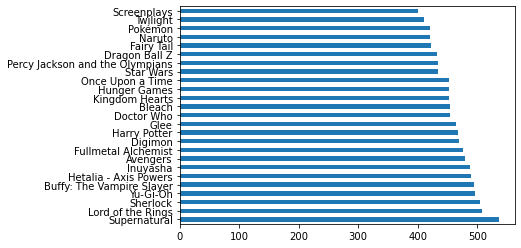

In [135]:
dfA.fandom.value_counts().plot(kind = 'barh')

<AxesSubplot:>

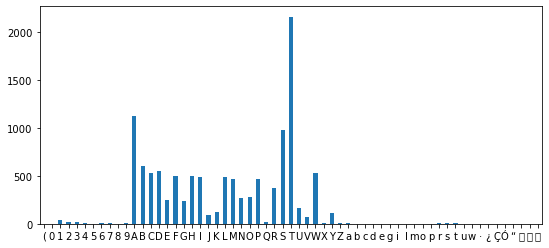

In [136]:
dfA.title.str[0].value_counts().sort_index().plot(kind='bar',figsize=(9,4),rot=0)

<AxesSubplot:>

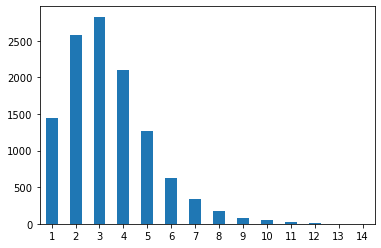

In [137]:
dfA.title.str.split(" ").apply(len).value_counts().sort_index().plot(kind='bar',rot=0)

<AxesSubplot:>

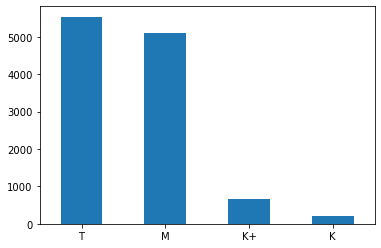

In [138]:
dfA.rating.value_counts().plot(kind='bar',rot=0)

<AxesSubplot:>

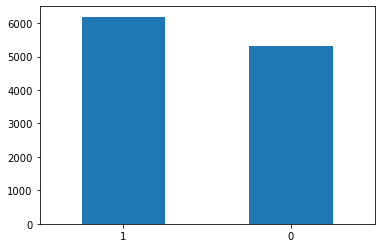

In [139]:
dfA.complete.value_counts().plot(kind='bar',rot=0)

<AxesSubplot:>

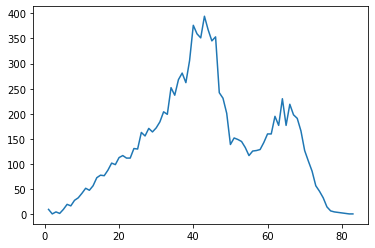

In [140]:
dfA.summary.str.split(" ").apply(len).value_counts().sort_index().plot(kind='line',rot=0)

<AxesSubplot:>

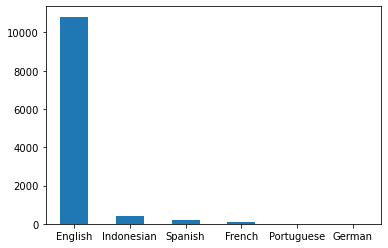

In [141]:
dfA.language.value_counts().plot(kind='bar',rot=0)

In [142]:
dfA.columns

Index(['index', 'fandom', 'title', 'href', 'complete', 'review', 'summary',
       'rating', 'language', 'genreA', 'genreB', 'chapters', 'wordCount',
       'reviewCount', 'favoriteCount', 'followCount', 'updateDate',
       'publishDate', 'characterList'],
      dtype='object')